In [1]:
using Base: Forward
using DiffEqFlux, OrdinaryDiffEq, Flux, Optim, Plots
using DiffEqSensitivity
using Zygote
using Sundials
using ForwardDiff
using LinearAlgebra
using Random
using Statistics
using ProgressBars, Printf
using Flux.Optimise: update!
using Flux.Losses: mae, mse
using BSON: @save, @load

In [2]:
# ===============
# generate data
n_input = 3;
n_samples = 1000;
rng = MersenneTwister(0x7777777);
x = rand(rng, n_input, n_samples);
a = rand(rng, n_input);
b = rand(rng, n_input);
y = sum(sin.(a .* x) .+ b, dims=1) + 0.05*(2*rand(rng, 1, n_samples).-1)

1×1000 Matrix{Float64}:
 3.12715  2.92376  2.83038  2.42395  …  2.37715  2.94499  2.56867  3.21806

In [3]:
# ===============
# setup networks
nn = Chain(
        Dense(n_input, 5),
        Dense(5, 1)
);
p_init, re = Flux.destructure(nn);
loss(p) = mse(re(p)(x), y);

In [4]:
# ===============
# train by adam
function train_SGD(p_init; opt=ADAM(0.01), n_epoch=1000)
    p_pred = deepcopy(p_init);
    losses = Vector{Float64}();
    for epoch in 1:n_epoch
        grad = Zygote.gradient(p->loss(p), p_pred)[1]
        update!(opt, p_pred, grad)
        push!(losses, loss(p_pred))
    end
    return p_pred, losses, (1:n_epoch)
end
function plot_loss(h, t, losses; line=(3,:solid), color=:blue, label="")
    plot!(h, t, losses, line=line, color=color, label=label, yscale=:log10)
    # plot(y', re(p_adam)(x)', line=:scatter, label="")
end


plot_loss (generic function with 1 method)

In [5]:
# ===============
# tain by ODE Solver
function dθdt!(dθ, θ, k, t)
    dθ .= -Zygote.gradient(p->loss(p), θ)[1]
end
# function Jac(θ, k, t)
#     return -ForwardDiff.jacobian(y -> Zygote.gradient(x -> loss(x), y)[1], θ)
# end
function train_ODE(p_init; solver=TRBDF2(), tend=1000)
    p_pred = deepcopy(p_init);
    losses = Vector{Float64}();
    prob = ODEProblem(dθdt!, p_pred, (0., tend))#; jac=Jac);
    sol = solve(prob, u0=p_pred, solver)#, atol=1e-15, maxiters=1000);
    # println(sol.destats)
    for p = sol.u
        push!(losses, loss(p))
    end
    p_pred = sol.u[end]
    return p_pred, losses, sol.t
end


train_ODE (generic function with 1 method)

lr = 0.1
 39.098972 seconds (99.11 M allocations: 6.314 GiB, 5.58% gc time, 99.83% compilation time)
lr = 0.03
  0.138945 seconds (161.87 k allocations: 108.859 MiB, 19.74% gc time)
lr = 0.01
  0.362256 seconds (486.03 k allocations: 326.892 MiB, 13.94% gc time)
lr = 0.003
  1.117983 seconds (1.62 M allocations: 1.064 GiB, 13.17% gc time)
name = "TRBDF2"
 48.064250 seconds (132.41 M allocations: 8.115 GiB, 4.73% gc time, 1.20% compilation time)
name = "Rosenbrock23"
  5.146909 seconds (10.73 M allocations: 1.071 GiB, 5.98% gc time, 92.74% compilation time)
name = "Tsit5"
  4.193566 seconds (7.66 M allocations: 522.881 MiB, 3.82% gc time, 96.91% compilation time)
name = "KenCarp4"


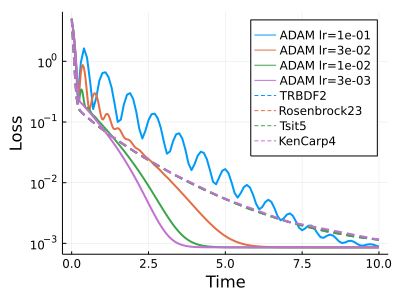

  3.968928 seconds (12.81 M allocations: 958.287 MiB, 4.90% gc time, 98.08% compilation time)


In [6]:
# solve for ADAM opts
h = plot(size=(400,300))
pa = palette(:default)
for (i,lr) in enumerate([0.1, 0.03, 0.01, 0.003])
    @show lr
    @time p, losses, t = train_SGD(p_init; opt=ADAM(lr), n_epoch=floor(10/lr))
    plot_loss(h, t.*lr, losses; line=(2,:solid), color=pa[i],
                label="$(@sprintf("ADAM lr=%.0e", lr))")
end

solvers = [
    ["TRBDF2",       TRBDF2()      ],
    ["Rosenbrock23", Rosenbrock23()],
    ["Tsit5",        Tsit5()       ],
    ["KenCarp4",     KenCarp4()    ],
]
for (i,(name,solver)) in enumerate(solvers)
    @show name
    @time p, losses, t = train_ODE(p_init; solver=solver, tend=10.)
    plot_loss(h, t, losses; line=(2,:dash), color=pa[i],
                label="$(@sprintf("%s", name))")
end
xlabel!(h, "Time")
ylabel!(h, "Loss")
png(h, "compare")
display(h)
